In [1]:
import pandas as pd
from scipy import stats
import scipy.stats as sc
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import heapq

import sys
sys.path.append('../script')
import common_function as CF

/tmp/ipykernel_1033868/2276975002.py:2: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  from scipy import stats


In [2]:
#path for summary of radius of gyration
reference_radius_path='../data/json/reference_radius.json'
isoform_radius_path='../data/json/isoform_radius.json'
difference_radius_path='../data/json/difference_radius.json'
plddt_IDR_isoform_path = '../data/json/plddt_IDR_isoform.json'
plddt_IDR_reference_path = '../data/json/plddt_IDR_reference.json'
#path for as event
as_event_path='../data/json/as_event.json'
reference_summary_path = '../data/csv/summary_reference.csv'
isoform_summary_path = '../data/csv/summary_isoform.csv'

In [3]:
def load_file_json(path):
    with open(path,'r') as load_f:
        file=json.load(load_f)
    return file

<span style="font-size: 20px;">Plot radius of gyration distribution: </span>

In [4]:
radius_reference = load_file_json(reference_radius_path)
radius_isoform = load_file_json(isoform_radius_path)
radius_difference = load_file_json(difference_radius_path)
plddt_IDR_isoform = load_file_json(plddt_IDR_isoform_path)
plddt_IDR_reference = load_file_json(plddt_IDR_reference_path)
as_event=load_file_json(as_event_path)
reference_summary=pd.read_csv(reference_summary_path)
isoform_summary=pd.read_csv(isoform_summary_path)

In [5]:
reference_high_confident = reference_summary[reference_summary['plddt']>=70.0]
isoform_high_confident = isoform_summary[isoform_summary['plddt']>=70.0]

In [6]:
reference_high = reference_summary[reference_summary['plddt']>=90.0]
isoform_high = isoform_summary[isoform_summary['plddt']>=90.0]

In [7]:
#select high and confident structures
radius_isoform,radius_reference,radius_difference = CF.combine_quality_metric(reference_high_confident,isoform_high_confident,radius_reference,radius_isoform,radius_difference)
isoform_radius_list=list(radius_isoform.values())
reference_radius_list=list(radius_reference.values())
statistic, p_value = stats.mannwhitneyu(isoform_radius_list,reference_radius_list)

In [10]:
#high and confident 
print('high and confident median radius for isoform:',np.median(isoform_radius_list))

#high only
print('high and confident radius for reference:',np.median(reference_radius_list))

#high only
print('high and confident pvalue:',p_value)

high and confident median radius for isoform: 27.46107294019553
high and confident radius for reference: 28.587748240154994
high and confident pvalue: 2.8767645940547078e-11


In [15]:
#select high structures
radius_isoform,radius_reference,radius_difference = CF.combine_quality_metric(reference_high,isoform_high,radius_reference,radius_isoform,radius_difference)
isoform_radius_list=list(radius_isoform.values())
reference_radius_list=list(radius_reference.values())
statistic, p_value = stats.mannwhitneyu(isoform_radius_list,reference_radius_list)

In [14]:
#high only
print('high median radius for isoform:',np.median(isoform_radius_list))

#high only
print('high median radius for reference:',np.median(reference_radius_list))

#high only
print('high pvalue:',p_value)

high median radius for isoform: 21.664840302573804
high median radius for reference: 22.909958972482713
high pvalue: 2.4829996654350025e-05


In [9]:
#plot distribtion
def plot_distribtion_box(isoform_radius,reference_radius,outliers = True):
    plot_df=pd.DataFrame(columns=['Class','Radius of gyration'])
    index=0
    radius_list=list(isoform_radius.values())+list(reference_radius.values())

    plot_df['Class']=['Isoform']*len(isoform_radius)+['Reference']*len(reference_radius)
    plot_df['Radius of gyration']=radius_list
    
    plt.figure(figsize=(2,4))
    box_colors = ['#F3BF70','#25D9F5']

    if outliers==False:
        sns.boxplot(x="Class",y="Radius of gyration",data=plot_df,palette="Set3",showfliers = False,notch=True)
    else:  
        sns.boxplot(x="Class",y="Radius of gyration",data=plot_df,flierprops = {'marker':'o','markerfacecolor':'black','markersize': 1},notch=True,width=0.8,palette=box_colors,order=['Reference','Isoform'])
    plt.xlabel('')

    plt.ylabel("Radius of gyration(Å)",fontsize=12)
    plt.xticks(fontsize=12)
    #plt.yticks(range(0, 130, 30),fontsize=12)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    #plt.savefig('radius_dis_high.png',dpi=600,bbox_inches='tight')
    plt.show()
    return plot_df

In [8]:
#select only high and confident structures and also 0 IDR stuructres
plddt_IDR_isoform_list=[]
for i in plddt_IDR_isoform:
    reference = i.split('-')[0]
    if plddt_IDR_isoform[i] == [] and reference in plddt_IDR_reference.keys():
        if plddt_IDR_reference[reference]==[] and i in list(isoform_high_confident['isoform']) and reference in list(reference_high_confident['reference']):
            plddt_IDR_isoform_list.append(i)

plddt_IDR_reference_list = list(set([i.split('-')[0] for i in plddt_IDR_isoform_list]))

In [9]:
plddt_IDR_reference_radius = {}
plddt_IDR_isoform_radius = {}
plddt_IDR_isoform_radius_diff = {}

for isoform in plddt_IDR_isoform_list:
    if isoform in radius_difference.keys():
        reference = isoform.split('-')[0]
        plddt_IDR_isoform_radius[isoform] = radius_isoform[isoform]
        plddt_IDR_reference_radius[reference] = radius_reference[reference]
        plddt_IDR_isoform_radius_diff[isoform] = radius_difference[isoform]
    else:
        print(isoform)

In [10]:
isoform_radius_IDR_list=list(plddt_IDR_isoform_radius.values())
reference_radius_IDR_list=list(plddt_IDR_reference_radius.values())
statistic, p_value = stats.mannwhitneyu(isoform_radius_IDR_list,reference_radius_IDR_list)

In [11]:
#non-IDR
print('non-IDR median radius for isoform:',np.median(isoform_radius_IDR_list))

#non-IDR
print('non-IDR radius for reference:',np.median(reference_radius_IDR_list))

#non-IDR
print('non-IDR pvalue:',p_value)

non-IDR median radius for isoform: 22.01093742085996
non-IDR radius for reference: 22.929924714407388
non-IDR pvalue: 1.6227181527213565e-05


In [11]:
np.median(isoform_radius_IDR_list)

22.01093742085996

In [12]:
np.median(reference_radius_IDR_list)

22.929924714407388

In [12]:
len(reference_radius_IDR_list)

1222

In [31]:
np.median(isoform_radius_IDR_list)-np.median(reference_radius_IDR_list)

-0.9189872935474277

22.929924714407388

In [28]:
p_value

1.6227181527213565e-05

In [17]:
#plot_distribtion_box(radius_isoform,radius_reference)

In [13]:
len(plddt_IDR_isoform_radius)

1770

[27.631369404784852, 35.40254711048089, 22.577174833644737, 23.56515258002443, 27.133842360398358, 36.002976068174725, 21.195216528491436, 26.62565261488399, 34.427728277440195, 43.047558583635805, 33.663578299465954, 26.784547990759116, 36.37657452390886, 17.766460781719502, 46.50007378030634, 44.136419898006004, 24.592523684591892, 41.26552818689238, 32.74054564031672, 33.400928808033996, 29.874870028962224, 16.587518328785524, 26.07956838779618, 14.832571609710781, 28.609400622388037, 32.646976313338435, 35.239965393945816, 33.98604954020348, 26.114534946151053, 25.835260983245256, 71.48486445742988, 27.211365585557793, 25.160849860720703, 37.24852133322762, 21.477116649173887, 29.642025856217888, 19.653353458307727, 19.69422431449815, 37.445557419317005, 22.471045859722274, 80.41682688420823, 68.5497872647685, 16.96690004992452, 33.07872233238342, 25.246361255142343, 13.248460112419165, 29.084699157023056, 54.13722226696968, 20.071341864935512, 19.942267065348982, 24.23975704208011

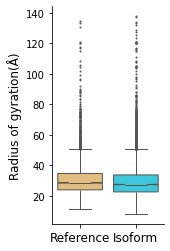

/tmp/ipykernel_3469734/3546073876.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class",y="Radius of gyration",data=plot_df,flierprops = {'marker':'o','markerfacecolor':'black','markersize': 1},notch=True,width=0.8,palette=box_colors,order=['Reference','Isoform'])


,Class,Radius of gyration
0,Isoform,26.232095
1,Isoform,33.301574
2,Isoform,18.691617
3,Isoform,31.025828
4,Isoform,23.020816
...,...,...
11063,Reference,14.386634
11064,Reference,37.517719
11065,Reference,63.398830
11066,Reference,19.471702


In [10]:
#for high
plot_distribtion_box(radius_isoform,radius_reference)

/tmp/ipykernel_2356945/3824088206.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Class",y="Radius of gyration",data=plot_df,flierprops = {'marker':'o','markerfacecolor':'black','markersize': 1},notch=True,width=0.8,palette=box_colors,order=['Reference','Isoform'])


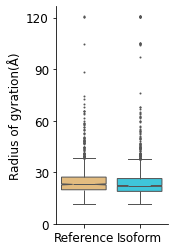

In [12]:
#for non-IDR dataset
plot_distribtion_box(plddt_IDR_isoform_radius,plddt_IDR_reference_radius)

In [ ]:
#radius_isoform_type,radius_difference_type=CF.combine_quality_type(radius_isoform,radius_difference,as_event)

In [14]:
#select the isoforms with alternative splicing types
isoform_radius_type_IDR,difference_radius_type_IDR=CF.combine_quality_type(plddt_IDR_isoform_radius,plddt_IDR_isoform_radius_diff,as_event)

In [18]:
#select the isoforms with alternative splicing types only for high
isoform_radius_type,difference_radius_type=CF.combine_quality_type(radius_isoform,radius_difference,as_event)

In [19]:
len(isoform_radius_type)

642

In [20]:
def plot_difference_outlier_box(difference_radius_type):
    difference_radius_type_new={}
    for isoform in difference_radius_type.keys():
        difference_radius_type_new[isoform]=difference_radius_type[isoform][0]
    plot_df = pd.DataFrame()
    plot_df['Isoform']=list(difference_radius_type_new.keys())
    plot_df['Radius of gyration difference']=list(difference_radius_type_new.values())
    plot_df['Class']='Isoform'
    fig = plt.figure(figsize=(2,4))
    box_colors = ['#25D9F5']
    sns.boxplot(data=plot_df, x='Class', y='Radius of gyration difference',flierprops = {'marker':'o','markerfacecolor':'black','markersize': 1},notch=True,width=0.8,palette=box_colors)
    plt.xlabel('')
    plt.ylabel('Radius of gyration difference(Å)',fontsize=12)
    plt.xticks(fontsize=12)
    #plt.yticks(range(-60, 40, 30),fontsize=12)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.savefig('radius_dif_high.png',dpi=600,bbox_inches='tight')
    plt.show()
    return plot_df

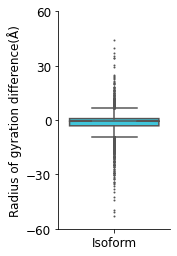

In [23]:
#plot_df=plot_difference_outlier_box(radius_difference_type)

/tmp/ipykernel_3301366/271213102.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='Class', y='Radius of gyration difference',flierprops = {'marker':'o','markerfacecolor':'black','markersize': 1},notch=True,width=0.8,palette=box_colors)


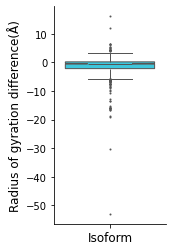

In [21]:
#only for high
plot_df=plot_difference_outlier_box(difference_radius_type)

/tmp/ipykernel_2356945/1804996470.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_df, x='Class', y='Radius of gyration difference',flierprops = {'marker':'o','markerfacecolor':'black','markersize': 1},notch=True,width=0.8,palette=box_colors)


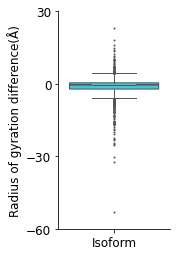

In [22]:
plot_df=plot_difference_outlier_box(difference_radius_type_IDR)

<span style="font-size: 20px;">Select outlier examples and plot the alternative splicing types in radius of gyration outliers: </span>

In [22]:
def calculate_outliters_radius(radius_difference_dic):
    radius_difference_list=[]
    for radius in radius_difference_dic.values():
        radius_difference_list.append(radius[0])
    Q1=np.percentile(radius_difference_list,25)
    Q3=np.percentile(radius_difference_list,75)
    IQR=1.5*(Q3-Q1)
    upper_bound=Q3+IQR
    lower_bound=Q1-IQR
    lower_list=[]
    upper_list=[]
    for k,v in radius_difference_dic.items():
        if v[0]>=upper_bound:
            upper_list.append(k)
        elif v[0]<=lower_bound:
            lower_list.append(k)
        else:
            continue
    return upper_list,lower_list,upper_bound,lower_bound

In [24]:
#only for high
upper_list,lower_list,upper_bound,lower_bound=calculate_outliters_radius(difference_radius_type)

In [18]:
upper_list,lower_list,upper_bound,lower_bound=calculate_outliters_radius(difference_radius_type_IDR)

In [25]:
def replace_as_abb_dic(plot_dic):
    new_plot_dic={}
    as_name_dic={'exon_skipping':'ES',
                 'alternative_donor_site':'ADS',
                 'alternative_acceptor_site':'AAS',
                 'mutually_exclusive_exon':'MXE',
                 'intron_retention':'IR',
                 'alternative_first_exon':'AFE',
                 'alternative_last_exon':'ALE',
                 'mutually_exclusive_exon-alternative_first_exon':'MXE-AFE',
                 'mutually_exclusive_exon-alternative_last_exon':'MXE-ALE'}
    for key in plot_dic.keys():
        new_plot_dic[as_name_dic[key]]=plot_dic[key]
    return new_plot_dic

In [26]:
def get_feature(charge_list,charge_dic):
    count_feature={}
    for isoform in charge_list:
        for feature in charge_dic[isoform][1]:
            if feature in count_feature.keys():
                count_feature[feature]+=1
            else:
                count_feature[feature]=1
    return count_feature

In [27]:
#only for high 
feature_upper=get_feature(upper_list,difference_radius_type)
feature_lower=get_feature(lower_list,difference_radius_type)

In [21]:
feature_upper_IDR=get_feature(upper_list,difference_radius_type_IDR)
feature_lower_IDR=get_feature(lower_list,difference_radius_type_IDR)

In [30]:
def plot_otlier_event_frequent_pair(positive_outlier,negative_outlier,threshold=5):
    selected_positive_outlier_pair = heapq.nlargest(threshold, positive_outlier.items(), key=lambda item: item[1])
    selected_negative_outlier_pair = heapq.nlargest(threshold, negative_outlier.items(), key=lambda item: item[1])
    sorted_positive_outlier = dict(selected_positive_outlier_pair)
    sorted_negative_outlier = dict(selected_negative_outlier_pair)
    sorted_positive_outlier = replace_as_abb_dic(sorted_positive_outlier)
    sorted_negative_outlier = replace_as_abb_dic(sorted_negative_outlier)
    
    as_list=list(sorted_positive_outlier.keys())
    positive_outlier_list=list(sorted_positive_outlier.values())
    #negative_outlier_list=[sorted_negative_outlier[i] for i in as_list]
    negative_outlier_list=list(sorted_negative_outlier.values())

    bar_width = 0.4
    bar1_positions = range(len(as_list))
    bar2_positions = [x + bar_width for x in bar1_positions]
 
    plt.bar(bar1_positions, positive_outlier_list, width=bar_width, label='positive',color='#000099')
    plt.bar(bar2_positions, negative_outlier_list, width=bar_width, label='negative',color='#FF0000')
    
    plt.xticks([x + bar_width/2 for x in bar1_positions], as_list,fontsize=14)
    plt.legend(fontsize=12)
    plt.xlabel('AS event type',fontsize=14)
    plt.ylabel('AS event number',fontsize=14)
    #plt.yticks(range(0, 310, 60),fontsize=14)
    plt.savefig('radius_as_type_high.png',dpi=600,bbox_inches='tight')
    plt.show()
    return True

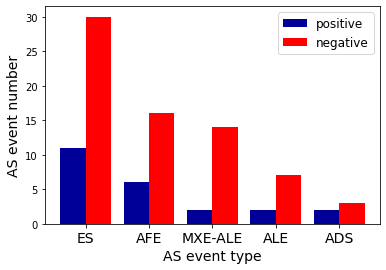

True

In [31]:
plot_otlier_event_frequent_pair(feature_upper,feature_lower)

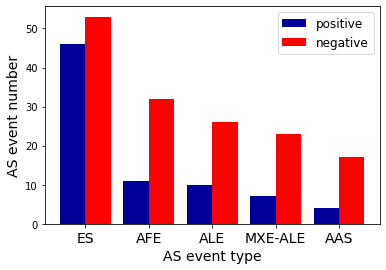

True

In [24]:
plot_otlier_event_frequent_pair(feature_upper_IDR,feature_lower_IDR)

In [32]:
feature_upper_IDR

{'alternative_last_exon': 10,
 'alternative_acceptor_site': 4,
 'exon_skipping': 46,
 'alternative_donor_site': 3,
 'mutually_exclusive_exon-alternative_last_exon': 7,
 'alternative_first_exon': 11,
 'intron_retention': 2,
 'mutually_exclusive_exon-alternative_first_exon': 2}

In [33]:
feature_lower_IDR

{'exon_skipping': 53,
 'alternative_last_exon': 26,
 'mutually_exclusive_exon-alternative_first_exon': 17,
 'mutually_exclusive_exon-alternative_last_exon': 23,
 'alternative_first_exon': 32,
 'alternative_acceptor_site': 8,
 'mutually_exclusive_exon': 3,
 'alternative_donor_site': 3}